In [ ]:
# Importing the python modules and the class ML_GRB from ML_GRB.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ML_GRB import ML_GRB

In [ ]:
# Initializing the class and reading the Spectral data
dir_path = ''
my_class = ML_GRB()
my_class.DataReading(dir_path)

In [ ]:
df = my_class.spectral_data_II

In [ ]:
# Splitting the dataset in i and p
df_i = df[(df['SType'] == 'i')].reset_index(drop=True)
df_p = df[(df['SType'] == 'p')].reset_index(drop=True)

# Removing from "i data" the GRBs that are not in "p data" (Because the "i GRBs Dataset" is bigger than the
# "p GRBs Dataset").
# Creating a mask to mark if the i-th element is in the "p dataframe"
condictions = []
count = 0
for i in df_i['ID']:
    condiction = i in df_p['ID'].values
    condictions.append(condiction)

# Using the mask to drop from "i dataframe" the row corresponding to GRBs that are not in "p dataframe"
for index, c in enumerate(condictions):
    if not c:
        df_i.drop(index, inplace=True)
        
for i in df_i['ID']:
    print(i)

In [ ]:
# Selecting Band from the two dataframe ("i" and "p") and CPL (with beta = -2.5) if there isn't Band

# Filtering the i and p data with Band fit
df_i_Band = df_i[df_i['SMod'] == 'Band'].reset_index(drop=True)
df_p_Band = df_p[df_p['SMod'] == 'Band'].reset_index(drop=True)

# Creating two list to see wich GRBs that are in i or p dataset are not in the filtered dataset with Band fit
p_list = []
i_list = []
for p in df_p['ID']:
    if not p in df_p_Band['ID'].values:
        p_list.append(p)
    
for i in df_i['ID']:
    if not i in df_i_Band['ID'].values:
        i_list.append(i)
    
# printing the list to show the GRBs of interest
print(p_list)
print(i_list)
        

In [ ]:
# Creating two DataFrame with the GRBs of interest in their CPL fit
df_i_CPL = df_i[df_i['ID'].isin(i_list) & (df_i['SMod'] == 'CPL')]
df_p_CPL = df_p[df_p['ID'].isin(p_list) & (df_p['SMod'] == 'CPL')]

# Replace beta with -2.5
df_i_CPL.loc[:, 'beta'] = -2.5
df_p_CPL.loc[:, 'beta'] = -2.5

# Assembling the CPL and Band dataframe sorting by ID for comparing consistency reasons
df_i_Band_CPL = pd.concat([df_i_Band, df_i_CPL], ignore_index=True)
df_p_Band_CPL = pd.concat([df_p_Band, df_p_CPL], ignore_index=True)

# Sorting by ID for comparing consistency reasons
df_i_Band_CPL_sorted = df_i_Band_CPL.sort_values(by=['ID'])
df_p_Band_CPL_sorted = df_p_Band_CPL.sort_values(by=['ID'])

# Resetting the index after the sorting process
final_df_i = df_i_Band_CPL_sorted.reset_index(drop=True)
final_df_p = df_p_Band_CPL_sorted.reset_index(drop=True)

# Debug
for temp1, temp2 in zip(df_p_Band_CPL['ID'].values, df_i_Band_CPL['ID'].values):
    print('{}\t{}'.format(temp1, temp2))

In [ ]:
# Rename the columns name of the variables of interest
final_df_i = final_df_i.rename(columns={'alpha': 'alpha_i', 
                           'beta': 'beta_i', 
                           'Ep': 'Ep_i', 
                           'F': 'F_i'})

final_df_p = final_df_p.rename(columns={'alpha': 'alpha_p', 
                           'beta': 'beta_p', 
                           'Ep': 'Ep_p', 
                           'F': 'F_p'})

# Combining the values of interest of the "i data" and the "p data"
dataset = pd.concat([final_df_i[['ID', 'DeltaT', 'alpha_i', 'beta_i', 'Ep_i', 'F_i']], 
                     final_df_p[['alpha_p', 'beta_p', 'Ep_p', 'F_p']]], axis=1)

# Debug
dataset.style

In [ ]:
# Extrating the redshift from the Burst Energetics data
BEdata = my_class.energetic_data

redshift = []
for name in dataset['ID']:
    temp_df = BEdata[BEdata['ID'] == name]
    z = temp_df.iloc[0]['z']
    redshift.append(z)
    
# Creating a dataframe for the redshift
temp_dict = {'z': redshift}
z_df = pd.DataFrame(temp_dict)

# Concatenating the dataset with the redshift dataframe
dataset = pd.concat([z_df, dataset[['DeltaT', 'alpha_i', 'beta_i', 'Ep_i', 
                                    'F_i', 'alpha_p', 'beta_p', 'Ep_p', 'F_p']]], 
                    axis=1)

# Debug
dataset.style

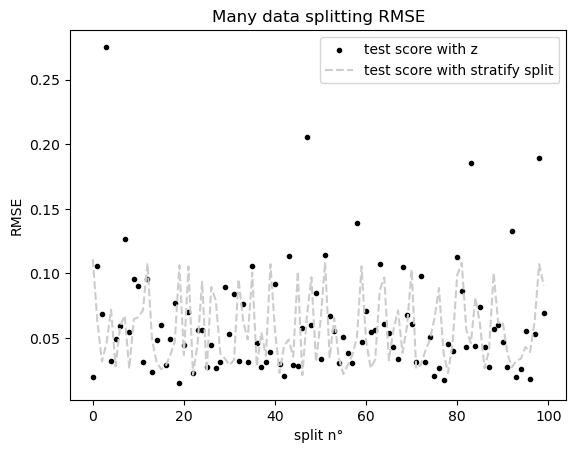

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from ML_GRB import ML_GRB, RND_FOREST

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

test_scores = []
test_scores_strat = []
for i in range(100):
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 13, random_state = i)
    
    test_scores.append(root_mean_squared_error(GRB.model.y_test, GRB.model.y_pred))

keys = []
for i in dataset['z']:
    if i <= 5:
        keys.append(0)
        
    elif i > 5:
        keys.append(1)
keys_arr = np.array(keys)

for i in range(100):
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset[['z', 'DeltaT','alpha_i', 'beta_i', 'Ep_i', 'F_i', 
                          'alpha_p', 'beta_p', 'Ep_p', 'F_p']], train_size = 0.8, stratify = keys_arr, 
                  n_estimators = 100, max_depth = 13, random_state = i)

    test_scores_strat.append(root_mean_squared_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting RMSE', 
    xlabel = 'split n°', 
    ylabel = 'RMSE'
)
ax.scatter(range(len(test_scores)), test_scores, marker='.', 
           color='k', label='test score with z')
ax.plot(range(len(test_scores_strat)), test_scores_strat, 
        linestyle='--', color='0.8', label='test score with stratify split')
ax.legend(loc='best')
plt.show()